<a href="https://colab.research.google.com/github/kmalq/401/blob/main/401.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate baseline/control dataset
-5000x201 dataset
-multivariate normal features
-5 true features, 195 noise
-balanced 4 class target, linear combination of the 5 features by creating linear score
-correlation matrix for collinearity, var=1 corr=0.1 off diagonals


In [ ]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define dataset dimensions
n = 5000    # total number of observations
p = 200     # total number of features

# Partition sizes for 80%, 10%, 10%
n1 = int(0.8 * n)  # 80% with "constant variance"
n2 = int(0.1 * n)  # 10% "completely non-constant"
n3 = n - n1 - n2   # remaining 10% "in-between"

##############################################################################
# 1) 80%: Original "constant variance" distribution (exchangeable correlation)
##############################################################################
rho = 0.1
Sigma_constant = np.full((p, p), rho)
np.fill_diagonal(Sigma_constant, 1.0)

X1 = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma_constant, size=n1)

##############################################################################
# 2) 10%: "Completely non-constant variance" distribution
#    - Example: A diagonal covariance with each feature having a random variance.
#    - No correlations (off-diagonals = 0).
##############################################################################
# Random diagonal variances, e.g. from Uniform(2, 5), just as an example
var_random = np.random.uniform(2, 5, p)
Sigma_nonconst = np.diag(var_random)

X2 = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma_nonconst, size=n2)

##############################################################################
# 3) 10%: "In-between"
#    - Example: Increase diagonal variances to 2, but keep smaller correlation ~0.05
##############################################################################
Sigma_inbetween = np.full((p, p), 0.05)
np.fill_diagonal(Sigma_inbetween, 2.0)

X3 = np.random.multivariate_normal(mean=np.zeros(p), cov=Sigma_inbetween, size=n3)

##############################################################################
# Combine into one feature matrix X
##############################################################################
X = np.vstack([X1, X2, X3])

##############################################################################
# 4) Build the target variable
#    - We use 5 "true" predictors and some noise, just like before.
##############################################################################
beta_true = np.array([1.0, -1.0, 0.5, 2.0, -0.5])
signal = X[:, :5].dot(beta_true) + np.random.normal(0, 1, n)

# Determine class boundaries based on quartiles of the signal
q1, q2, q3 = np.percentile(signal, [25, 50, 75])

# Assign classes 0, 1, 2, 3 based on the signal quartiles
Y = np.where(signal <= q1, 0,
    np.where(signal <= q2, 1,
        np.where(signal <= q3, 2, 3)))

##############################################################################
# 5) Combine into a pandas DataFrame
##############################################################################
columns = [f'X{i+1}' for i in range(p)]
df = pd.DataFrame(X, columns=columns)
df['Target'] = Y

# Display basic information
print('Dataset shape:', df.shape)
print('Target class distribution:')
print(df['Target'].value_counts().sort_index())


Dataset shape: (5000, 201)
Target class distribution:
Target
0    1250
1    1250
2    1250
3    1250
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
import sci-kitlearn

# Step 2: Fit a linear regression model on the 5 signal features
X_signal = df[['X1', 'X2', 'X3', 'X4', 'X5']]
y_signal = signal  # We're using the original signal as the dependent variable
model = LinearRegression().fit(X_signal, y_signal)

# Step 3: Compute residuals
predicted = model.predict(X_signal)
residuals = y_signal - predicted

# Step 4: Standardize residuals
standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Step 5: Plot histogram like in ggplot2
plt.figure(figsize=(8, 5))
plt.hist(standardized_residuals, bins=np.arange(-3, 3.2, 0.2), color='brown', edgecolor='brown')
plt.title("Checking for Normality")
plt.xlabel("Standardized Residuals")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (<ipython-input-19-39db7bc2066d>, line 2)

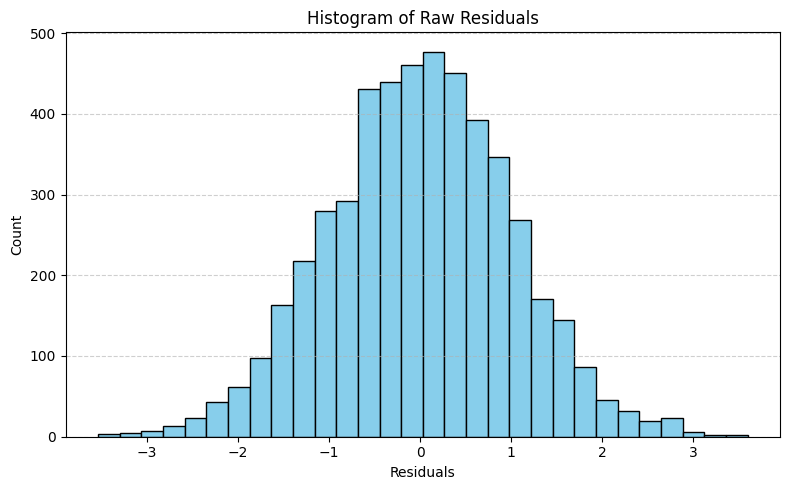

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black')
plt.title("Histogram of Raw Residuals")
plt.xlabel("Residuals")
plt.ylabel("Count")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

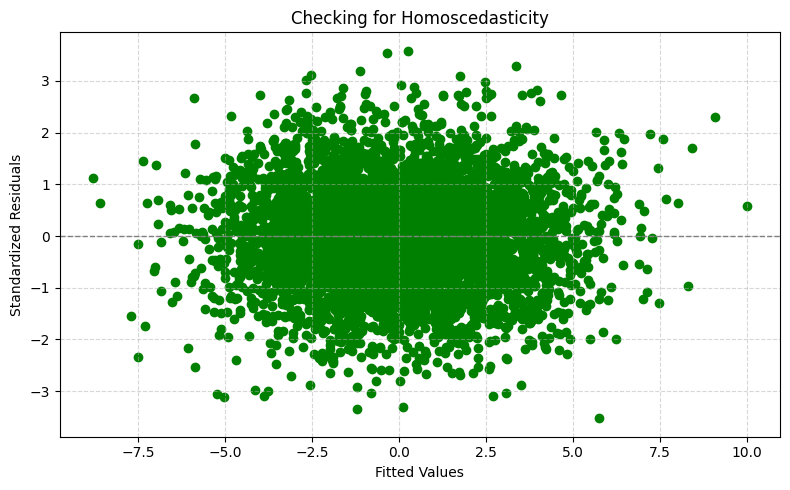

In [ ]:
# Fitted values from the linear model
fitted_values = predicted  # already computed earlier

# Standardized residuals from earlier
# standardized_residuals = (residuals - np.mean(residuals)) / np.std(residuals)

# Create scatter plot
plt.figure(figsize=(8, 5))
plt.scatter(fitted_values, standardized_residuals, color='green')
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.title("Checking for Homoscedasticity")
plt.xlabel("Fitted Values")
plt.ylabel("Standardized Residuals")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Add intercept (constant) to feature matrix
X_with_const = add_constant(X[:, :200])  # using only the 5 true predictors

# Compute VIF for each predictor
vif_data = pd.DataFrame()
vif_data['Feature'] = ['Intercept'] + [f'X{i+1}' for i in range(200)]
vif_data['VIF'] = [variance_inflation_factor(X_with_const, i) for i in range(X_with_const.shape[1])]

# Display VIFs
vif_data


,Feature,VIF
0,Intercept,1.047394
1,X1,1.120412
2,X2,1.112497
3,X3,1.126992
4,X4,1.114742
...,...,...
196,X196,1.132997
197,X197,1.124031
198,X198,1.117857
199,X199,1.122824


# Inject outliers

In [14]:
import numpy as np
import pandas as pd

# --- Parameters you can tune ---
distance_levels = {
    'Low': 2,     # e.g., ~2 standard deviations from the mean
    'Medium': 4,  # e.g., ~4 standard deviations from the mean
    'High': 6     # e.g., ~6 standard deviations from the mean
}
proportion_levels = {
    'Low': 0.05,  # e.g., 5% of the data
    'Medium': 0.10,
    'High': 0.20
}

# We will create a dictionary to store DataFrames for each combo
outlier_dataframes = {}

# Pre-calculate the means and standard deviations for each feature
feature_cols = [col for col in df.columns if col.startswith('X')]
means = df[feature_cols].mean()
stds  = df[feature_cols].std()

for dist_label, dist_value in distance_levels.items():
    for prop_label, prop_value in proportion_levels.items():
        # 1. Copy the original dataframe
        df_out = df.copy(deep=True)

        # 2. Calculate how many outliers we need
        n_outliers = int(prop_value * len(df_out))

        # 3. Randomly pick which rows will become outliers
        outlier_indices = np.random.choice(df_out.index, size=n_outliers, replace=False)

        # 4. Shift the selected rows by 'dist_value' standard deviations
        #    Here we shift every feature column, but you might choose to shift
        #    only a subset of columns if you prefer.
        for col in feature_cols:
            # Shift upwards by dist_value * std for that column
            df_out.loc[outlier_indices, col] += dist_value * stds[col]

        # 5. Compute an outlier score in [0,1]
        #    One simple scaling is to divide distance by the max distance in distance_levels
        #    and proportion by the max proportion in proportion_levels, then multiply.
        max_dist = max(distance_levels.values())
        max_prop = max(proportion_levels.values())

        outlier_score = (dist_value / max_dist) * (prop_value / max_prop)
        df_out['OutlierScore'] = outlier_score

        # 6. Store in dictionary with a clear name, e.g., ('Low','High') -> 'Low_High'
        combo_name = f"{dist_label}_{prop_label}"
        outlier_dataframes[combo_name] = df_out

# Now you have 9 new DataFrames, each accessible via outlier_dataframes['Low_Low'],
# outlier_dataframes['Low_Medium'], ..., outlier_dataframes['High_High'].
print("Created the following outlier DataFrames:")
for k in outlier_dataframes.keys():
    print(k, outlier_dataframes[k].shape)



Created the following outlier DataFrames:
Low_Low (5000, 202)
Low_Medium (5000, 202)
Low_High (5000, 202)
Medium_Low (5000, 202)
Medium_Medium (5000, 202)
Medium_High (5000, 202)
High_Low (5000, 202)
High_Medium (5000, 202)
High_High (5000, 202)


,Dataset,Distance,Proportion,OutlierScore,MeanAbsShift,NumOutliers
0,Low_Low,Low,Low,0.083333,2.323101,250
1,Low_Medium,Low,Medium,0.166667,2.323101,500
2,Low_High,Low,High,0.333333,2.323101,1000
3,Medium_Low,Medium,Low,0.166667,4.646203,250
4,Medium_Medium,Medium,Medium,0.333333,4.646203,500
5,Medium_High,Medium,High,0.666667,4.646203,1000
6,High_Low,High,Low,0.250000,6.969304,250
7,High_Medium,High,Medium,0.500000,6.969304,500
8,High_High,High,High,1.000000,6.969304,1000


<ipython-input-15-1f4e380ce9ed>:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=outlier_stats_df, x='Dataset', y='MeanAbsShift', palette='viridis')


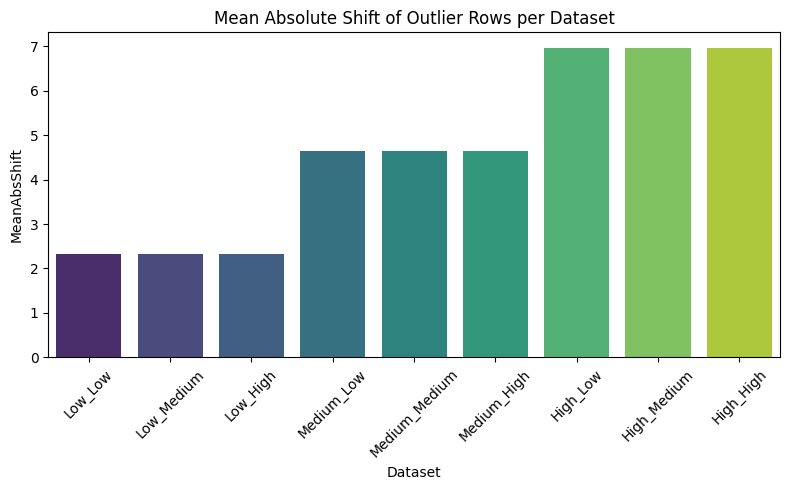

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# List all feature columns
feature_cols = [col for col in df.columns if col.startswith('X')]

# Prepare a list to accumulate statistics for each outlier dataset
outlier_stats = []

for combo_name, df_out in outlier_dataframes.items():
    # combo_name will be something like "Low_Low", "Medium_High", etc.
    dist_label, prop_label = combo_name.split('_')

    # The difference between the outlier dataframe and the original dataframe
    # across all feature columns.
    diff = df_out[feature_cols] - df[feature_cols]

    # Identify which rows actually got changed. We’ll assume that any row
    # with a non-zero difference in at least one feature is considered “modified.”
    changed_mask = diff.abs().sum(axis=1) > 1e-9  # sum of abs differences > tiny threshold

    # Calculate the mean absolute shift for the modified rows (the outliers).
    # This is a simple scalar that indicates, on average, how far the outlier rows
    # have been moved from their original values.
    if changed_mask.sum() > 0:
        mean_abs_shift = diff[changed_mask].abs().values.mean()
    else:
        mean_abs_shift = 0.0  # No rows changed

    # Retrieve the uniform OutlierScore for that dataset (stored in each row)
    outlier_score = df_out['OutlierScore'].iloc[0]

    # Count how many rows were actually designated as outliers
    num_outliers = changed_mask.sum()

    outlier_stats.append({
        'Dataset': combo_name,
        'Distance': dist_label,
        'Proportion': prop_label,
        'OutlierScore': outlier_score,
        'MeanAbsShift': mean_abs_shift,
        'NumOutliers': num_outliers
    })

# Convert list of dicts into a DataFrame for easy plotting
outlier_stats_df = pd.DataFrame(outlier_stats)

# --- Print or tabulate the summary for clarity ---
display(outlier_stats_df)

# --- Plot a bar chart of the mean absolute shift to visualize differences ---
plt.figure(figsize=(8,5))
sns.barplot(data=outlier_stats_df, x='Dataset', y='MeanAbsShift', palette='viridis')
plt.xticks(rotation=45)
plt.title('Mean Absolute Shift of Outlier Rows per Dataset')
plt.tight_layout()
plt.show()



# XGBoost

# Random Forest

# Logistic Regression

# HFMOEA

# MOSA

# MOPSO